In [7]:
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV,\
                                    StratifiedKFold, KFold,\
                                    StratifiedShuffleSplit, RepeatedStratifiedKFold, \
                                    cross_val_score, cross_validate
                                    
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import check_random_state
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier

from mne.decoding import cross_val_multiscore, LinearModel, \
                         GeneralizingEstimator, Scaler, Vectorizer

import cvxpy as cp

In [8]:
class arguments():
    def __init__(self):
        self.DATAPATH = '../data/'

args = arguments()

train = pd.read_csv(args.DATAPATH + 'studentspen-train.csv')
test = pd.read_csv(args.DATAPATH + 'studentsdigits-test.csv')

X = train[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
Y = train['Digit'].values
print(X.shape)
print(Y.shape)

(3747, 8)
(3747,)


# Normalization and standardization

/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


(3747, 8)
(3747, 8)


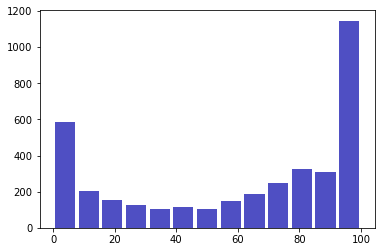

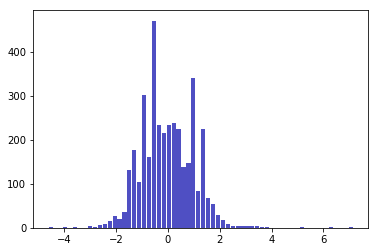

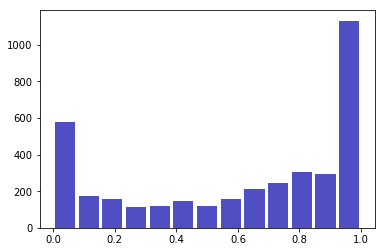

In [9]:
train_stand = train.copy()
train_norm = train.copy()


train_standa = train.copy()
train_norma = train.copy()

train_normlog = train.copy()
train_standlog = train.copy()
train_log = train.copy()

for feat in ['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']:
    train_stand[feat] = train_stand.groupby('Digit')[feat].transform(lambda x: (x - x.mean()) / x.std())
    train_norm[feat] = train_norm.groupby('Digit')[feat].transform(lambda x: (x - x.min()) / (x.max()-x.min()) )
    train_standa[feat] = train_stand.groupby('Digit').transform(lambda x: (x - x.mean()) / x.std())
    train_norma[feat] = train_norm.groupby('Digit').transform(lambda x: (x - x.min()) / (x.max()-x.min()) )

    train_normlog[feat] = train_norm.groupby('Digit').transform(lambda x: np.log(x) )
    train_standlog[feat] = train_stand.groupby('Digit').transform(lambda x: np.log(x) )
    train_log[feat] = train.groupby('Digit').transform(lambda x: np.log(x) )
    
X_norm = train_norm[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
Y_norm = train_norm['Digit'].values

X_stand = train_stand[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
Y_stand = train_stand['Digit'].values

X_standa = train_standa[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
Y_standa = train_standa['Digit'].values

X_norma = train_norma[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
Y_norma = train_norma['Digit'].values

# no log transformation since it give NaN or -inf if the x are zero or negarive


print(X_norm.shape)
print(X_stand.shape)
# plot
feat = 'x6'

data = train[feat]
plt.hist(x=data, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()


data = train_standa[feat]
plt.hist(x=data, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

data = train_norm[feat]
plt.hist(x=data, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()
     

# Create classifiers

In [10]:
rand_state=45
max_iter=100000

In [11]:
# n_split for linear = 10 and for polynomial = 6
n_split_linear=10
n_split_poly=6

cv1 = StratifiedShuffleSplit(n_splits=n_split_linear, random_state=rand_state) 
cv2 = StratifiedShuffleSplit(n_splits=n_split_poly, random_state=rand_state) 

In [26]:
le = LabelEncoder()

In [27]:
bsvc = SVC(kernel='linear')
psvc = SVC(kernel='poly', gamma='scale')
psvc2 = SVC(kernel='poly', gamma='auto')
lsvc = LinearSVC()
lsvc_l1 = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, tol=1e-3, \
                    max_iter=max_iter)
lsvc2 = make_pipeline(StandardScaler(), LinearModel(LinearSVC(random_state=rand_state,\
                                                              max_iter=max_iter)))
lsvc3 = make_pipeline(StandardScaler(), LinearModel(SVC(kernel='linear', \
                                                        random_state=rand_state, \
                                                        max_iter=max_iter)))           

paramSearch  = np.logspace(-2.3, -1.3, 10)
clf_sets = [(bsvc, paramSearch, X, Y),
            (lsvc, paramSearch, X, Y),
            (lsvc_l1, paramSearch, X, Y),
            (lsvc2, paramSearch, X, Y),
            (lsvc3, paramSearch, X, Y)]

# Question 1 and 2

Question 1): Train a  linear multi-class classification SVM with no kernel.  Specify i) Your mapping function and ii) Your loss function  (20 points)

Question 2) Describe a method to estimate your performance using an empirical method. Compare this estimate with a well known theoretical bound. Explain why/if there is a difference. (5 points)

In [28]:
# class sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale',\
                       #coef0=0.0, shrinking=True, probability=False, \
                       #tol=0.001, cache_size=200, class_weight=None, \
                       #verbose=False, max_iter=-1, \
                       #decision_function_shape='ovr',\
                       #break_ties=False, random_state=None)[source]¶

# possible Hyperparams

class_weight='balanced'

early_stopping=True

learning_rate='optimal' # instead tune alpha

epsilon=0.1 #default is 0.1

shuffle=True # so for each epoch data will be shuffled

max_iter=1000 #dafualt is 1000

alpha = 0.0001 # regularization term , the higher the stronger the regularization

penalty = 'l2' #default is l2

loss = 'hinge' #default is hinge, possible options

--- The possible options are ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, 
‘perceptron’, or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’.

In [ ]:
# Do NOT run again
bsvc_scores     = cross_val_score(bsvc, X, Y, cv=cv1, n_jobs=1)
print(bsvc_scores)
print(np.mean(bsvc_scores))

# Tuning parameter C for SVC for  kernel = 'linear'
C = 8

In [ ]:
# Do NOT run again

scores=[]
range_params = np.array([2,4,6,8,9,10])
for ic, cc in enumerate(range_params):
    lsvc3 = make_pipeline(StandardScaler(), LinearModel(SVC(kernel='linear', C=cc, \
                                                            random_state=rand_state, \
                                                            max_iter=max_iter)))           

    lsvc3_scores     = cross_val_score(lsvc3, X, Y, cv=cv1)
    sc = np.mean(lsvc3_scores)
    scores.append(sc)
    print('C is ', cc, 'gives score', sc)
    


In [ ]:
# Do NOT run again

bsvc = SVC(kernel='linear', C=8, random_state=rand_state, max_iter=max_iter)
bsvc_scores     = cross_val_score(lsvc3, X, Y, cv=cv1, n_jobs=1)
print(bsvc_scores)
print(np.mean(bsvc_scores))

## check if normalization or standardization helped
Nope it did not!

In [87]:
# # Do NOT run again
# # check on normalized data

# bsvc = SVC(kernel='linear', C=8, random_state=rand_state, max_iter=max_iter)
# bsvc_scores     = cross_val_score(lsvc3, X_norm, Y_norm, cv=cv1, n_jobs=1)
# print(bsvc_scores)
# print(np.mean(bsvc_scores))

# # Do NOT run again
# # check on normalized data

# bsvc = SVC(kernel='linear', C=8, random_state=rand_state, max_iter=max_iter)
# bsvc_scores     = cross_val_score(lsvc3, X_stand, Y_stand, cv=cv1, n_jobs=1)
# print(bsvc_scores)
# print(np.mean(bsvc_scores))

# # [0.78933333 0.82133333 0.792      0.824      0.79733333 0.848
# #  0.82933333 0.79466667 0.83466667 0.82933333]
# # 0.8160000000000001
# # [0.15733333 0.12533333 0.104      0.12       0.16266667 0.16
# #  0.10933333 0.12533333 0.14666667 0.09333333]
# # 0.13040000000000002


# # Do NOT run again
# # check on normalized data

# bsvc = SVC(kernel='linear', C=8, random_state=rand_state, max_iter=max_iter)
# bsvc_scores     = cross_val_score(lsvc3, X_norma, Y_norma, cv=cv1, n_jobs=1)
# print(bsvc_scores)
# print(np.mean(bsvc_scores))

# # Do NOT run again
# # check on normalized data

# bsvc = SVC(kernel='linear', C=8, random_state=rand_state, max_iter=max_iter)
# bsvc_scores     = cross_val_score(lsvc3, X_standa, Y_standa, cv=cv1, n_jobs=1)
# print(bsvc_scores)
# print(np.mean(bsvc_scores))


# # [0.26666667 0.25333333 0.272      0.20266667 0.25333333 0.22133333
# #  0.25866667 0.25066667 0.23466667 0.256     ]
# # 0.2469333333333333
# # [0.10666667 0.104      0.10133333 0.11466667 0.112      0.104
# #  0.10666667 0.09066667 0.09866667 0.09866667]
# # 0.10373333333333332

# Best model so far

In [50]:
# Do NOT run again

# checking class_weight='balanced' -> does not matter 
bsvc = SVC(kernel='linear', C=8, random_state=rand_state, max_iter=max_iter,\
           class_weight='balanced')
bsvc_scores     = cross_val_score(lsvc3, X, Y, cv=cv1, n_jobs=1)
print(bsvc_scores)
print(np.mean(bsvc_scores))

[0.864      0.896      0.872      0.87733333 0.872      0.888
 0.86933333 0.84533333 0.87466667 0.90933333]
0.8767999999999999


In [54]:
# Do NOT run again

# checking gamma -> does not matter to set to a specific number
range_params =np.logspace(-1, 10, 10)
for al in range_params:
    bsvc = SVC(kernel='linear', C=8, random_state=rand_state, max_iter=max_iter,\
               class_weight='balanced', gamma=al)
    bsvc_scores     = cross_val_score(lsvc3, X, Y, cv=cv1, n_jobs=1)
    print(np.mean(bsvc_scores))

0.8767999999999999
0.8767999999999999
0.8767999999999999
0.8767999999999999
0.8767999999999999
0.8767999999999999
0.8767999999999999
0.8767999999999999
0.8767999999999999
0.8767999999999999


In [56]:
# Do NOT run again

# checking gamma -> does not matter to be scale or auto
bsvc = SVC(kernel='linear', C=8, random_state=rand_state, max_iter=max_iter,\
           class_weight='balanced', gamma='auto')
bsvc_scores     = cross_val_score(lsvc3, X, Y, cv=cv1, n_jobs=1)
print(np.mean(bsvc_scores))

# checking gamma
bsvc = SVC(kernel='linear', C=8, random_state=rand_state, max_iter=max_iter,\
           class_weight='balanced', gamma='scale')
bsvc_scores     = cross_val_score(lsvc3, X, Y, cv=cv1, n_jobs=1)
print(np.mean(bsvc_scores))

0.8767999999999999
0.8767999999999999


In [114]:
# #https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py
# # Nested vs non nested cross validation

# # Number of random trials
# NUM_TRIALS = 30
# rand_state=45

# rand_state=45
# max_iter=1000000

# # Set up possible values of parameters to optimize over
# # p_grid = {"C": [1, 10, 100],
# #           "gamma": [.01, .1]}
# # Set the parameters by cross-validation
# # tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-1, 1e-2, 1e-3, 1e-4],
# #                      'C': [1, 10, 100, 1000]},
# #                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
# tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 50]}]




# # We will use a Support Vector Classifier with "linear" kernel
# bsvc = SVC(random_state=rand_state, max_iter=max_iter)
# estim =  bsvc         

# # Arrays to store scores
# non_nested_scores = np.zeros(NUM_TRIALS)
# nested_scores = np.zeros(NUM_TRIALS)

# # Loop for each trial
# for i in range(NUM_TRIALS):
#     print('start i %s' %i)
#     # Choose cross-validation techniques for the inner and outer loops,
#     # independently of the dataset.
#     # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.

#     inner_cv = StratifiedShuffleSplit(n_splits=10, random_state=i) 
# #     inner_cv = KFold(n_splits=10, shuffle=True, random_state=i)
#     outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)

#     # Non_nested parameter search and scoring
#     print('start inner')
#     clf = GridSearchCV(estimator=estim, param_grid=tuned_parameters, cv=inner_cv)
# #     clf = GridSearchCV(estimator=estim, param_grid=p_grid, cv=inner_cv)
#     clf.fit(X, Y)
#     non_nested_scores[i] = clf.best_score_

#     # Nested CV with parameter optimization
#     print('start inner')
#     nested_score = cross_val_score(clf, X=X, y=Y, cv=outer_cv)
#     nested_scores[i] = nested_score.mean()

# score_difference = non_nested_scores - nested_scores

# print("Average difference of {:6f} with std. dev. of {:6f}."
#       .format(score_difference.mean(), score_difference.std()))

# # Plot scores on each trial for nested and non-nested CV
# plt.figure()
# plt.subplot(211)
# non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
# nested_line, = plt.plot(nested_scores, color='b')
# plt.ylabel("score", fontsize="14")
# plt.legend([non_nested_scores_line, nested_line],
#            ["Non-Nested CV", "Nested CV"],
#            bbox_to_anchor=(0, .4, .5, 0))
# plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
#           x=.5, y=1.1, fontsize="15")

# # Plot bar chart of the difference.
# plt.subplot(212)
# difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
# plt.xlabel("Individual Trial #")
# plt.legend([difference_plot],
#            ["Non-Nested CV - Nested CV Score"],
#            bbox_to_anchor=(0, 1, .8, 0))
# plt.ylabel("score difference", fontsize="14")

# plt.show()



In [63]:
# Do NOT run again

# check deafult for cross validation, setting cv to integer 10, it will be kfold or kstratified 

bsvc = SVC(kernel='linear', C=8, random_state=rand_state, max_iter=max_iter)
bsvc_scores     = cross_val_score(lsvc3, X, Y, cv=10)
print(np.mean(bsvc_scores))

0.8551056860183566


# Checking other classifiers
SVC is way better than linearSVC

In [17]:
lsvc_scores     = cross_val_score(lsvc, X, Y, cv=cv1, n_jobs=1)
print(lsvc_scores)

[0.592      0.37866667 0.41866667 0.46933333 0.48266667 0.536
 0.55733333 0.528      0.33066667 0.48      ]


In [62]:
# lsvc_scores     = cross_val_score(lsvc, X, Y, cv=cv1, n_jobs=1)
print(lsvc_scores)

[0.592      0.37866667 0.41866667 0.46933333 0.48266667 0.536
 0.55733333 0.528      0.33066667 0.48      ]


In [18]:
lsvc_l1_scores  = cross_val_score(lsvc_l1, X, Y, cv=cv1, n_jobs=1)
print(lsvc_l1_scores)

[0.736      0.752      0.73333333 0.71466667 0.712      0.74133333
 0.73866667 0.712      0.73866667 0.73333333]


# Conclusions
1. It might be easier to use GridSearch, but faster to do it separately to have a general idea
1.1. So far I got C=8 for kernel ='linear', and n_splits=10 gave me the best result, gamma was not affecting the results
1.2. I tried to double check that with 
2. It might be a better cross validation to do a nested and non-nested cross validation
3. For being able to plot I might need to use cross predict: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py

4. SVC was way better than linearSVC
5. For transfer learning i might be able to use cross predict

# Question 3
Question 3) Submit your predictions on this test set, one prediction per line in the order given studentsdigits-test.csvPreview the document (10 points)

# Question 4
Question 4) Implement both types of transfer learning SVM (hypothesis and instance transfer) to train 1 vs 7 (target problem) by transferring in 1 vs 9 (source problem). Report your error estimate for the target problem with i) no transfer, ii) hypothesis transfer and iii) instance transfer. Which performs better? Why? (20 points)

In [29]:
fit_intercept=False
def gen_data(fit_intercept):

    grp1 = train[train['Digit']==1]
    grp7 = train[train['Digit']==7]
    grp9 = train[train['Digit']==9]

    if fit_intercept==False:
        grp1['b'] = 1
        grp7['b'] = 1
        grp9['b'] = 1

        X1 = grp1[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'b']].values
        Y1 = grp1['Digit'].values

        X7 = grp7[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'b']].values
        Y7 = grp7['Digit'].values

        X9 = grp9[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'b']].values
        Y9 = grp9['Digit'].values
    else:
        X1 = grp1[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
        Y1 = grp1['Digit'].values

        X7 = grp7[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
        Y7 = grp7['Digit'].values

        X9 = grp9[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
        Y9 = grp9['Digit'].values

    Y7 = -1*np.ones([Y7.shape[0]])
    Y9 = -1*np.ones([Y9.shape[0]])

    X1_orig = X1.copy()
    Y1_orig = Y1.copy()

    print(X7.shape)
    print(Y7.shape)
    return X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig

In [30]:
def gen_source_target(fit_intercept):
    #--------------------------------------------------------------------------------------
    X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
    #--------------------------------------------------------------------------------------
    # Source
    #--------------------------------------------------------------------------------------
    X19 = np.concatenate((X1, X9),axis=0)
    Y19 = np.concatenate((Y1, Y9),axis=0)

    print(X19.shape, Y19.shape)
    grp19 = np.zeros([X19.shape[0], X19.shape[1]+1])
    grp19[:,:-1] = X19
    grp19[:,-1] = Y19
    #--------------------------------------------------------------------------------------
    X_source = X19.copy()
    Y_source = Y19.copy()
    #--------------------------------------------------------------------------------------
    # Target
    #--------------------------------------------------------------------------------------
    X17 = np.concatenate((X1, X7),axis=0)
    Y17 = np.concatenate((Y1, Y7),axis=0)

    print(X19.shape, Y17.shape)
    grp17 = np.zeros([X17.shape[0], X17.shape[1]+1])
    grp17[:,:-1] = X17
    grp17[:,-1] = Y17
    #--------------------------------------------------------------------------------------
    X_target = X17.copy()
    Y_target = Y17.copy()
    #--------------------------------------------------------------------------------------
    return X_source, Y_source, X_target, Y_target

In [31]:
# n_split for linear = 10 and for polynomial = 6
n_split_linear=10
n_split_poly=6

cv1 = StratifiedShuffleSplit(n_splits=n_split_linear, random_state=rand_state) 
cv2 = StratifiedShuffleSplit(n_splits=n_split_poly, random_state=rand_state) 

In [32]:
rand_state=45
max_iter=100000

# No transfer with Sklearn

In [33]:
# clf_src = make_pipeline(StandardScaler(), LinearModel(LinearSVC(random_state=rand_state, \
#                                                                 max_iter=max_iter, \
#                                                                 fit_intercept=fit_intercept)))
clf_src = make_pipeline(StandardScaler(), LinearSVC(random_state=rand_state, \
                                                                max_iter=max_iter, \
                                                                fit_intercept=fit_intercept))

bsvc_tr = make_pipeline(StandardScaler(), LinearModel(SVC(kernel='linear', \
                                                          random_state=rand_state, \
                                                          max_iter=max_iter)))

### conclustion:
only LinearSVC has fit_intercept, so to be able to augment data and not use intercept, I prefer to use this, however, most of the times SVC with kernel='linear' gives a better score. So here I have checked it and it seems the scores of both LinearSVC and SVC with kernel='linear' are pretty close. So I will use LinearSVC at the end with fit_intercept=False.

In [34]:
#--------------------------------------------------------------------------------------
# Source
#--------------------------------------------------------------------------------------
X19 = np.concatenate((X1, X9),axis=0)
Y19 = np.concatenate((Y1, Y9),axis=0)

print(X19.shape, Y19.shape)
grp19 = np.zeros([X19.shape[0], X19.shape[1]+1])
grp19[:,:-1] = X19
grp19[:,-1] = Y19
#--------------------------------------------------------------------------------------
X_source = X19.copy()
Y_source = Y19.copy()
#--------------------------------------------------------------------------------------
print(' Source Scores ---------------------')
clf_src_scores1    = cross_val_score(bsvc_tr, X_source, Y_source, cv=cv1, n_jobs=1)
# print(clf_src_scores1)
print(np.mean(clf_src_scores1))
print('------------------------------------')
clf_trg_scores2    = cross_val_score(clf_src, X_source, Y_source, cv=cv1, n_jobs=1)
# print(clf_trg_scores2)
print(np.mean(clf_trg_scores2))
print('------------------------------------')


#--------------------------------------------------------------------------------------
# Target
#--------------------------------------------------------------------------------------
X17 = np.concatenate((X1, X7),axis=0)
Y17 = np.concatenate((Y1, Y7),axis=0)

print(X19.shape, Y17.shape)
grp17 = np.zeros([X17.shape[0], X17.shape[1]+1])
grp17[:,:-1] = X17
grp17[:,-1] = Y17

#--------------------------------------------------------------------------------------
X_target = X17.copy()
Y_target = Y17.copy()
#--------------------------------------------------------------------------------------
print(' Target Scores ---------------------')
clf_trg_scores1    = cross_val_score(bsvc_tr, X_target, Y_target, cv=cv1, n_jobs=1)
# print(clf_trg_scores1)
print(np.mean(clf_trg_scores1))
print('------------------------------------')
clf_trg_scores2    = cross_val_score(clf_src, X_target, Y_target, cv=cv1, n_jobs=1)
# print(clf_trg_scores2)
print(np.mean(clf_trg_scores2))
print('------------------------------------')


(1137, 9) (1137,)
 Source Scores ---------------------
0.9157894736842106
------------------------------------
0.8807017543859649
------------------------------------
(1137, 9) (1154,)
 Target Scores ---------------------
0.9103448275862067
------------------------------------
0.8646551724137931
------------------------------------


## check if I get the same score with a solver
### Conclusion: even though every time the index for train and test are different but at the end the average over all epochs is same! so all epochs have same performance!! 

In [35]:
def calc_perf(x1, x2):
    nn = x1.shape[0]
    scores = np.zeros([nn, 1])
    for ii in range(nn):
        if x1[ii]==x2[ii]:
            scores[ii] = 1
        else:
            scores[ii] = 0
    corr = np.sum(scores, axis=0)
    perf = (corr / nn) * 100
    return corr, perf

def calc_err(x1, x2):
    nn = x1.shape[0]
    scores = np.zeros([nn, 1])
    for ii in range(nn):
        if x1[ii]!=x2[ii]:
            scores[ii] = 1
        else:
            scores[ii] = 0
    incorr = np.sum(scores, axis=0)
    incorr_prcng = (incorr / nn) * 100
    return incorr, incorr_prcng

# No transfer - With Solver

Conclusion: I have check adding "(1 - epsilon.value)" when I was calculating scores, some notes:
        
This is only for train data since I created epsilon only for training data and not test, 

I got worse peformance when I used it (train: 69.63609898%, test: 87.53246753) compare to when I do not add this (train: 89.82532751%, test: 87.53246753)

Still having the issue that everything is same over blocks!

In [19]:
n_epochs=10

/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to

(374, 9)
(374,)
(374, 9)
(374,)
(747, 9) (747,)
(747, 9) (764,)
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
[[89.79621543]
 [89.79621543]
 [89.79621543]
 [89.79621543]
 [89.79621543]
 [89.79621543]
 [89.79621543]
 [89.79621543]
 [89.79621543]
 [89.79621543]]
[[87.66233766]
 [87.66233766]
 [87.66233766]
 [87.66233766]
 [87.66233766]
 [87.66233766]
 [87.66233766]
 [87.66233766]
 [87.66233766]
 [87.66233766]]


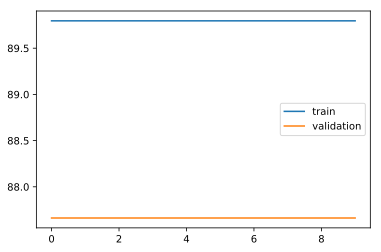

In [483]:
#--------------------------------------------------------------------------------------
X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
X_source, Y_source, X_target, Y_target = gen_source_target(fit_intercept)
#--------------------------------------------------------------------------------------
X17 = X_target.copy()
Y17 = Y_target.copy()
#--------------------------------------------------------------------------------------
cv1 = StratifiedShuffleSplit(n_splits=n_split_linear, random_state=rand_state) 
#--------------------------------------------------------------------------------------
corrs_train = np.zeros([n_epochs, n_split_linear, 1])
perfs_train = np.zeros([n_epochs, n_split_linear, 1])
corrs_test = np.zeros([n_epochs, n_split_linear, 1])
perfs_test = np.zeros([n_epochs, n_split_linear, 1])
#--------------------------------------------------------------------------------------
for ep, epochs in enumerate(range(n_epochs)):
    cv1 = StratifiedShuffleSplit(n_splits=n_split_linear, random_state=rand_state) 
    print('epoch:', ep)
    ii=0
    for trg_train_index, trg_test_index in cv1.split(X17, Y17):
        X_train = X17[trg_train_index,:].copy()
        y_train = Y17[trg_train_index].copy()
        y_train = y_train[:, np.newaxis]
        #----------------------------------------------------------------------------------
        X_test = X17[trg_test_index,:].copy()
        y_test = Y17[trg_test_index].copy()
        #----------------------------------------------------------------------------------
        D = X_train.shape[1]# feature dimension
        N = X_train.shape[0]
        epsilon = cp.Variable((N, 1))
        w = cp.Variable((D, 1))
        P = np.diag(np.ones(D))
        #----------------------------------------------------------------------------------
        # b = cp.Variable()
        # I have augmented data by 1, so I do not need any 'b'
        #----------------------------------------------------------------------------------
        objective = cp.Minimize(cp.sum_squares(w) * 0.5 + cp.sum(cp.square(epsilon)*C))
        constraints = [cp.multiply(y_train, (X_train @ w)) >= 1 - epsilon, epsilon >= 0]
        prob = cp.Problem(objective, constraints)
        prob.solve()
        #----------------------------------------------------------------------------------
#         Should figure this out
#         projections = (X.dot(w.value) + b.value) - (1 - epsilon.value) 
#         y_test_pred = np.sign(X_test.dot(w.value) - (1 - epsilon.value) )
        #----------------------------------------------------------------------------------
        y_test_pred = np.sign(X_test.dot(w.value))
        corr, perf = calc_perf(y_test_pred, y_test)
        corrs_test[ep, ii]=corr
        perfs_test[ep, ii]=perf
        #----------------------------------------------------------------------------------
#         y_train_pred = np.sign(X_train.dot(w.value) - (1 - epsilon.value))
        y_train_pred = np.sign(X_train.dot(w.value))
        corr, perf = calc_perf(y_train_pred, y_train)
        corrs_train[ep, ii]=corr
        perfs_train[ep, ii]=perf
        #----------------------------------------------------------------------------------
        ii+=1
# w_source_withSolver_noTrans = w.copy()
#-----------------------------------------------------------------------------------------
corrs_epch_test = np.mean(corrs_test, axis=1)
perfs_epch_test = np.mean(perfs_test, axis=1)
corrs_epch_train = np.mean(corrs_train, axis=1)
perfs_epch_train = np.mean(perfs_train, axis=1)
#-----------------------------------------------------------------------------------------
print(perfs_epch_train)
print(perfs_epch_test)
plt.plot(range(n_epochs), perfs_epch_train, label='train')
plt.plot(range(n_epochs), perfs_epch_test, label='validation')
plt.legend()
#-----------------------------------------------------------------------------------------

# Hypothesis Transfer with Solver 
good link for tuning C/lambda: https://www.cvxpy.org/examples/machine_learning/svm.html

In [20]:
clf_src = make_pipeline(StandardScaler(), LinearSVC(random_state=rand_state, \
                                                                max_iter=max_iter, \
                                                                fit_intercept=fit_intercept))

In [21]:
#--------------------------------------------------------------------------------------
n_epochs=10
#--------------------------------------------------------------------------------------
# featW=True #train~ 90, validation < 30
featW=False #train~ 93, validation ~ 88
#--------------------------------------------------------------------------------------
# If featW was True set this to False! They should be doing similar
dublicateX1=True
#--------------------------------------------------------------------------------------
# range_n_splits=[5,10,20] # It seems split=10 could be reasonable one
range_n_splits=[10]
#--------------------------------------------------------------------------------------
# testSizes=[0.1, 0.2, 0.3, 0.4, 0.5] # It seems, 0.3 could be a reaonable one
testSizes=[0.5]
#--------------------------------------------------------------------------------------
TRIALS = 10
C_vals = np.logspace(-1, 0, TRIALS)

/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to

(374, 9)
(374,)
10
[89.48762737 89.48617176 89.46724891 89.47889374 89.47161572 89.48034934
 89.48762737 89.48908297 89.48326055 89.48180495]
[89.20779221 89.20779221 89.22077922 89.25974026 89.23376623 89.23376623
 89.22077922 89.19480519 89.19480519 89.15584416]


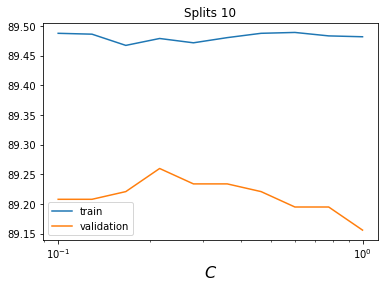

In [22]:
#--------------------------------------------------------------------------------------
X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
#--------------------------------------------------------------------------------------

for nsp in range_n_splits:
    corrs_train = np.zeros([nsp, n_split_linear, TRIALS])
    perfs_train = np.zeros([nsp, n_split_linear, TRIALS])
    corrs_test = np.zeros([nsp, n_split_linear, TRIALS])
    perfs_test = np.zeros([nsp, n_split_linear, TRIALS])
    print(nsp)
    #-----------------------------------------------------------------------------------------
    for ts in testSizes:
        #--------------------------------------------------------------------------------------
        cv = StratifiedShuffleSplit(n_splits=nsp, random_state=rand_state, test_size=ts)
        #--------------------------------------------------------------------------------------
        if dublicateX1: 
            X1 = X1_orig.copy()
            Y1 = Y1_orig.copy()
            X1 = np.concatenate((X1, X1), axis=0)
            Y1 = np.concatenate((Y1, Y1), axis=0)
        else:
            X1 = X1_orig.copy()
            Y1 = Y1_orig.copy()
        #--------------------------------------------------------------------------------------
        for x1fld, (X1_src_tr_index, X1_trg_te_index) in enumerate(cv.split(X1, Y1)):
            #----------------------------------------------------------------------------------
            #print('X1 target shape', X1[X1_trg_te_index].shape, 'X7 source shape', X7.shape)
            #print('-------------------------------------------------')
            #print('X1 source shape', X1[X1_src_tr_index].shape, 'X9 target shape', X9.shape, '\n')
            X17 = np.concatenate((X1[X1_trg_te_index], X7),axis=0)
            Y17 = np.concatenate((Y1[X1_trg_te_index], Y7),axis=0)
            grp17 = np.zeros([X17.shape[0], X17.shape[1]+1])
            grp17[:,:-1] = X17
            grp17[:,-1] = Y17

            X19 = np.concatenate((X1[X1_src_tr_index,:], X9),axis=0)
            Y19 = np.concatenate((Y1[X1_src_tr_index], Y9),axis=0)
            grp19 = np.zeros([X19.shape[0], X19.shape[1]+1])
            grp19[:,:-1] = X19
            grp19[:,-1] = Y19
            #----------------------------------------------------------------------------------
            X_source = X19.copy()
            Y_source = Y19.copy()

            X_target = X17.copy()
            Y_target = Y17.copy()
            #----------------------------------------------------------------------------------
            # I calculated this way so the one with fewer samples would have more weight, so the 
            # enumerator is same and the denomerator is the number of samples
            Imp1 =   X_target.shape[0] / X1[X1_trg_te_index].shape[0]
            Imp7 =   X_target.shape[0] / X7.shape[0]
            #----------------------------------------------------------------------------------
            cv2 = StratifiedShuffleSplit(n_splits=n_split_linear, random_state=rand_state)
            #----------------------------------------------------------------------------------
            for cvtrgt, (trg_train_index, trg_test_index) in enumerate(cv2.split(X17, Y17)):
                #----------------------------------------------------------------------------------
                X_train = X17[trg_train_index,:].copy()
                y_train = Y17[trg_train_index].copy()
                y_train = y_train[:, np.newaxis]
                #----------------------------------------------------------------------------------
                X_test = X17[trg_test_index,:].copy()
                y_test = Y17[trg_test_index].copy()
                #----------------------------------------------------------------------------------        
                clf_src.fit(X_source, Y_source)
                #----------------------------------------------------------------------------------
                epsilon = cp.Variable((X_train.shape[0], 1))
                w_source = clf_src.named_steps['linearsvc'].coef_.T
                D = X_train.shape[1]# feature dimension
                N = X_train.shape[0]
                P = np.diag(np.ones(D))
                w_d = cp.Variable((D, 1))
                w_d.value = w_source
                #----------------------------------------------------------------------------------
                X=X_train.copy()
                y=y_train.copy()
                C = cp.Parameter(nonneg=True)
                objective = cp.Minimize(cp.sum_squares(w_d) * 0.5 + cp.sum(cp.square(epsilon)*C))
                #----------------------------------------------------------------------------------
                if featW:
                    Imp=[]
                    for yy in y_train:
                        if yy == 1:
                            Imp.append(Imp1*yy)
                        elif yy == -1:
                            Imp.append(Imp7*yy)
                    Imp = np.asarray(Imp)        
                    constraints = [cp.multiply(cp.multiply(Imp, y), \
                                   (X @ (w_source + w_d))) >= 1 - epsilon, \
                                   epsilon >= 0]
                else:
                    constraints = [cp.multiply(y, \
                                   (X @ (w_source + w_d))) >= 1 - epsilon, \
                                   epsilon >= 0]
                #----------------------------------------------------------------------------------
                prob = cp.Problem(objective, constraints)
                #----------------------------------------------------------------------------------
                # Compute a trade-off curve and record train and test error.                        
                for cc in range(TRIALS):
                    C.value = C_vals[cc]
                    prob.solve()
                    #----------------------------------------------------------------------------------
                    w_trgt = w_source + w_d
                    #----------------------------------------------------------------------------------
                    y_test_pred = np.sign(X_test.dot(w_trgt.value))
                    corr, perf = calc_err(y_test_pred, y_test)
                    corr, perf = calc_perf(y_test_pred, y_test)
                    corrs_test[x1fld, cvtrgt, cc]=corr
                    perfs_test[x1fld, cvtrgt, cc]=perf
                    #----------------------------------------------------------------------------------
                    y_train_pred = np.sign(X_train.dot(w_trgt.value))
                    corr, perf = calc_err(y_train_pred, y_train)
                    corr, perf = calc_perf(y_train_pred, y_train)
                    corrs_train[x1fld, cvtrgt, cc]=corr
                    perfs_train[x1fld, cvtrgt, cc]=perf
                    #----------------------------------------------------------------------------------
    train_scores_flds     = np.mean(perfs_train, axis=0)
    validation_scores_flds= np.mean(perfs_test, axis=0)
    train_scores_flds     = np.mean(train_scores_flds, axis=0)
    validation_scores_flds= np.mean(validation_scores_flds, axis=0)
    #------------------------------------------------------------------------------------------    
    print(train_scores_flds)
    print(validation_scores_flds)
    #------------------------------------------------------------------------------------------
    plt.plot(C_vals, train_scores_flds, label='train')
    plt.plot(C_vals, validation_scores_flds, label='validation')
    plt.xlabel(r"$C$", fontsize=16)
    plt.xscale('log')
    plt.title('Splits %s' %(nsp))
    plt.legend()
    plt.show()

Check the results for tuning regularizarion term lambda/C, (n_split chose to be 10, and test_size to 0.5)

Conclusion: it turns out C=0.21 is the best

In [23]:
best_C = np.argmax(validation_scores_flds)
print('best C is: ', C_vals[best_C])
print(perfs_train.shape)
print(best_C)
best_score_train      = np.mean(perfs_train[:,:, best_C], axis=(0,1))
best_score_validation = np.mean(perfs_test[:,:, best_C], axis=(0,1))
print(best_score_train, best_score_validation)

best C is:  0.21544346900318834
(10, 10, 10)
3
89.47889374090249 89.25974025974024


## plot hypothesis transfer learning

In [24]:
class arguments():
    def __init__(self):
        self.DATAPATH = '../data/'

args = arguments()

train = pd.read_csv(args.DATAPATH + 'studentspen-train.csv')
test = pd.read_csv(args.DATAPATH + 'studentsdigits-test.csv')

X = train[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
Y = train['Digit'].values
print(X.shape)
print(Y.shape)

(3747, 8)
(3747,)


In [25]:
# X_target_plt = X.copy()
# y_train = Y.copy()

In [2]:
clf_src = make_pipeline(StandardScaler(), LinearSVC(C=best_C, random_state=rand_state, \
                                                                max_iter=max_iter, \
                                                                fit_intercept=fit_intercept))

NameError: name 'make_pipeline' is not defined

NameError: name 'c2' is not defined

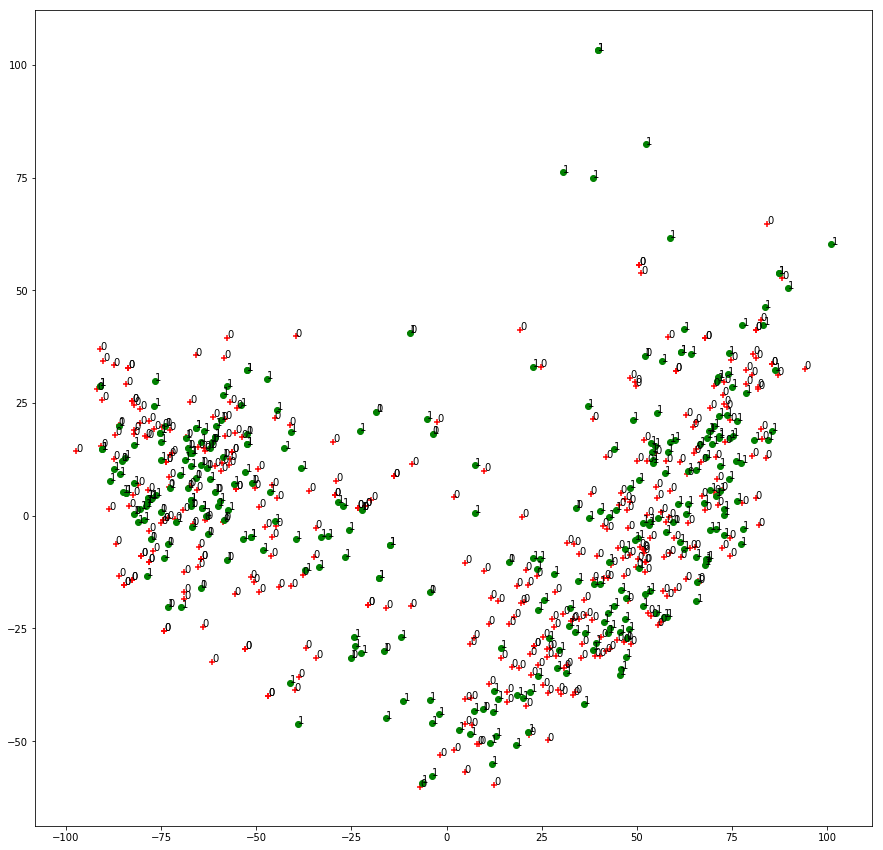

In [37]:
import matplotlib.pylab as pl
from sklearn.decomposition import PCA

prob=='target'

leg_label=''
if prob=='target':
    pca = PCA(n_components=2).fit(X_target_plt)
    pca_2d = pca.transform(X_target_plt)
    y_train = y_target_plt.copy()
    leg_label = 'digit 7'
elif prob=='source':
    pca = PCA(n_components=2).fit(X_source_plt)
    pca_2d = pca.transform(X_source_plt)
    y_train = y_source_plt.copy()
    leg_label = 'digit 9'

fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111)

for i in range(0, pca_2d.shape[0]):
    if y_train[i] == 1:
        c0 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='r', marker='+', s=100)
    elif y_train[i] == -1:
        c1 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='b', marker='_', s=100)
#     ax.annotate(str(y_train[i]), (pca_2d[i,0],pca_2d[i,1]))
pl.legend([c0, c1],\
          ['digit 1', '%s' %leg_label])
pl.title('Instance transfer for %s problem' %prob, fontweight='bold', fontsize=22)
clf_src.fit(X_source, Y_source)
#----------------------------------------------------------------------------------  
svclassifier_2d = clf_src            
# svclassifier_2d = SVC(kernel='linear')
svclassifier_2d.fit(pca_2d, y_train)
#----------------------------------------------------------------------------------  
decision_function = clf_src.named_steps['linearsvc'].decision_function(pca_2d)                
eps=1
sup = y_train * decision_function
support_vector_indices = np.where((-eps<sup) & (sup<eps))[0]
sup_vecs = pca_2d[support_vector_indices]
for i in range(0, pca_2d.shape[0]):
    if np.sum(support_vector_indices==i)==1:
        if y_train[i] == 1:
            c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y',  marker='+', s=400)
        if y_train[i] == -1:
            c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',  marker='_', s=400)


pl.legend([c2],\
          ['support vecs'])
#----------------------------------------------------------------------------------  
x_min, x_max = pca_2d[:, 0].min() - 1,   pca_2d[:,0].max() + 1
y_min, y_max = pca_2d[:, 1].min() - 1,   pca_2d[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 10),   np.arange(y_min, y_max, 10))

Z = svclassifier_2d.predict(np.c_[xx.ravel(),  yy.ravel()])
Z = Z.reshape(xx.shape)
pl.contour(xx, yy, Z)

#     pl.title('Support Vector Machine Decision Surface', fontweight='bold', fontsize=22)
pl.axis('off')
pl.show()



print('done')

NameError: name 'c1' is not defined

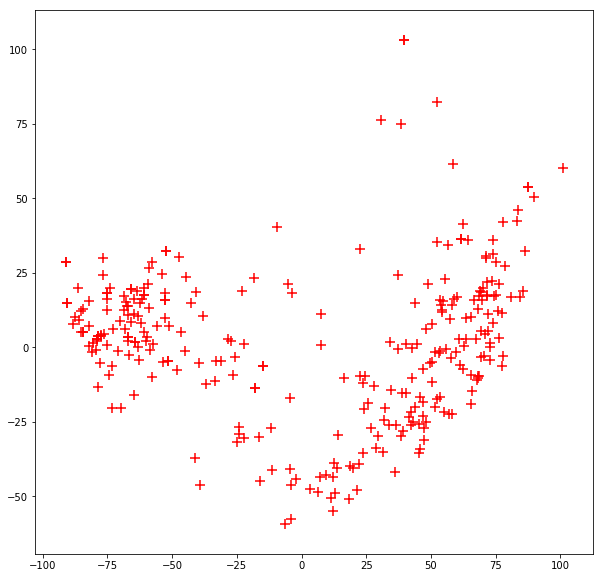

In [32]:
import matplotlib.pylab as pl
from sklearn.decomposition import PCA

leg_label=''

pca = PCA(n_components=2).fit(X_target_plt)
pca_2d = pca.transform(X_target_plt)

fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111)
                     
for i in range(0, pca_2d.shape[0]):
    if y_train[i] == 1:
        c0 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='r', marker='+', s=100)
    elif y_train[i] == -1:
        c1 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='b', marker='_', s=100)
    
#     ax.annotate(str(y_train[i]), (pca_2d[i,0],pca_2d[i,1]))
    
pl.legend([c0, c1],\
          ['digit 1', '%s' %leg_label])
pl.title('Instance transfer for %s problem' %prob)

clf_src.fit(X_source, Y_source)
                

#----------------------------------------------------------------------------------  
svclassifier_2d = clf_src            
# svclassifier_2d = SVC(kernel='linear')
svclassifier_2d.fit(pca_2d, y_train)
#----------------------------------------------------------------------------------  
# decision_function = clf_src.named_steps['linearsvc'].decision_function(pca_2d)                
# eps=1
# sup = y_train * decision_function
# support_vector_indices = np.where((-eps<sup) & (sup<eps))[0]
# sup_vecs = pca_2d[support_vector_indices]
# for i in range(0, pca_2d.shape[0]):
#     if np.sum(support_vector_indices==i)==1:
#         if y_train[i] == 1:
#             c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y',  marker='+', s=400)
#         if y_train[i] == -1:
#             c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',  marker='_', s=400)


# pl.legend([c2],\
#           ['support vecs'])
#----------------------------------------------------------------------------------  
x_min, x_max = pca_2d[:, 0].min() - 1,   pca_2d[:,0].max() + 1
y_min, y_max = pca_2d[:, 1].min() - 1,   pca_2d[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 10),   np.arange(y_min, y_max, 10))

Z = svclassifier_2d.predict(np.c_[xx.ravel(),  yy.ravel()])
Z = Z.reshape(xx.shape)
pl.contour(xx, yy, Z)
pl.title('Support Vector Machine Decision Surface', fontweight='bold', fontsize=22)
pl.axis('off')
pl.show()



print('done')

# Instance Learning

#### First check how to get support vectors:
some notes;

LinearSVC does not give support vectors but it has fit_intercept boolean and I augnemnted all of my data so I want to use this boolean

however, SVC that gives support vectors as output does not have the boolearn fit_intercept

So the question is how to get support vectors out of LinearSVC and whether it is same when I use SVC


In [ ]:
clf_src = make_pipeline(StandardScaler(), LinearSVC(random_state=rand_state, \
                                                                max_iter=max_iter, \
                                                                fit_intercept=fit_intercept))

bsvc_tr = make_pipeline(StandardScaler(), SVC(kernel='linear', \
                                                          random_state=rand_state, \
                                                          max_iter=max_iter))

In [ ]:
#--------------------------------------------------------------------------------------
n_epochs=10
#--------------------------------------------------------------------------------------
# featW=True #train~ 90, validation < 30
featW=False #train~ 93, validation ~ 88
#--------------------------------------------------------------------------------------
# If featW was True set this to False! They should be doing similar
dublicateX1=True
#--------------------------------------------------------------------------------------
# range_n_splits=[5,10,20] # It seems split=10 could be reasonable one
range_n_splits=[10]
#--------------------------------------------------------------------------------------
# testSizes=[0.1, 0.2, 0.3, 0.4, 0.5] # It seems, 0.3 could be a reaonable one
testSizes=[0.5]
#--------------------------------------------------------------------------------------
TRIALS = 10
C_vals = np.logspace(-1, 0, TRIALS)

In [ ]:
eps = 1e-8 # select support vectors

In [ ]:
bsvc_tr.named_steps

### Checking how to get support vectors
I have compared SVC, LinearSVC and solver for all source data. So it seems SVC and LinearSVC ae more flexible and cosider all data below<=1 as support vectors, however, in solver, TA only transferred those that are very close to 1. The way he did it is: defined an epsilon (eps), because it wont be well defined to only say supportvecotrs==1, so he defined a VERY SMALL epsilon (eps) and said -eps < supportvectors - 1 <eps which means supportvectors - 1 is very close to zero or in other words it is very close to 1. 

In [ ]:
#----------------------------------------------------------------------------------
X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
X_source, Y_source, X_target, Y_target = gen_source_target(fit_intercept)
#----------------------------------------------------------------------------------
clf_src.fit(X_source, Y_source)
bsvc_tr.fit(X_source, Y_source)
#----------------------------------------------------------------------------------        
# using this link 
# https://scikit-learn.org/stable/auto_examples/svm/plot_linearsvc_support_vectors.html
decision_function = clf_src.named_steps['linearsvc'].decision_function(X_source)
# we can also calculate the decision function manually
# decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
support_vector_indices = np.where((Y_source) * decision_function <= 1)[0]
sv_X = X_source[support_vector_indices]
sv_y = Y_source[support_vector_indices]
print('support_vectors1------', support_vectors.shape)
#----------------------------------------------------------------------------------        
support_vectors = bsvc_tr.named_steps['svc'].support_vectors_
print('support_vectors2------', support_vectors.shape)
#----------------------------------------------------------------------------------        
# Ge's code
D = X_source.shape[1]# feature dimension
N = X_source.shape[0]
epsilon = cp.Variable((N, 1))
sv_epsilon = cp.Variable((support_vector_indices.shape[0], 1))
w = cp.Variable((D, 1))
P = np.diag(np.ones(D))
objective = cp.Minimize(cp.sum_squares(w) * 0.5 + cp.sum(cp.square(epsilon)*C))
Y_source=Y_source[:,np.newaxis]
constraints = [cp.multiply(Y_source, (X_source @ w)) >= 1 - epsilon, epsilon >= 0]
prob = cp.Problem(objective, constraints)
prob.solve()

eps_range=[1e-15, 1e-14, 1e-8, 1e-2]
for eps in eps_range:
    print('*****',Y_source.shape, w.shape, X_source.shape)
    sup = Y_source*(X_source.dot(w.value)) - 1
    sup_v1 = ((-eps<sup) & (sup<eps)).flatten()
    print('eps', eps, '; support_vectors3_1------', np.sum((sup_v1).astype(int)))
    print('\n')

/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to

(374, 9)
(374,)
10
support_vectors1------ (11,)
[87.67540029 87.68704512 87.69286754 87.71615721 87.70305677 87.69868996
 87.70014556 87.70305677 87.71615721 87.70742358]
[87.75324675 87.77922078 87.77922078 87.77922078 87.68831169 87.67532468
 87.66233766 87.66233766 87.64935065 87.66233766]


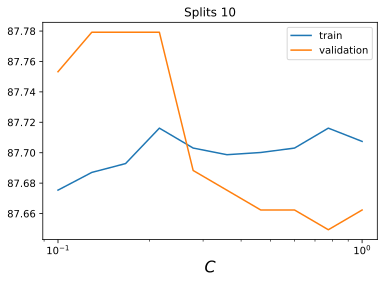

In [563]:
#--------------------------------------------------------------------------------------
X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
#--------------------------------------------------------------------------------------

for nsp in range_n_splits:
    corrs_train = np.zeros([nsp, n_split_linear, TRIALS])
    perfs_train = np.zeros([nsp, n_split_linear, TRIALS])
    corrs_test = np.zeros([nsp, n_split_linear, TRIALS])
    perfs_test = np.zeros([nsp, n_split_linear, TRIALS])
    print(nsp)
    #-----------------------------------------------------------------------------------------
    for ts in testSizes:
        #--------------------------------------------------------------------------------------
        cv = StratifiedShuffleSplit(n_splits=nsp, random_state=rand_state, test_size=ts)
        #--------------------------------------------------------------------------------------
        if dublicateX1: 
            X1 = X1_orig.copy()
            Y1 = Y1_orig.copy()
            X1 = np.concatenate((X1, X1), axis=0)
            Y1 = np.concatenate((Y1, Y1), axis=0)
        else:
            X1 = X1_orig.copy()
            Y1 = Y1_orig.copy()
        #--------------------------------------------------------------------------------------
        for x1fld, (X1_src_tr_index, X1_trg_te_index) in enumerate(cv.split(X1, Y1)):
            #----------------------------------------------------------------------------------
            #print('X1 target shape', X1[X1_trg_te_index].shape, 'X7 source shape', X7.shape)
            #print('-------------------------------------------------')
            #print('X1 source shape', X1[X1_src_tr_index].shape, 'X9 target shape', X9.shape, '\n')
            X17 = np.concatenate((X1[X1_trg_te_index], X7),axis=0)
            Y17 = np.concatenate((Y1[X1_trg_te_index], Y7),axis=0)
            grp17 = np.zeros([X17.shape[0], X17.shape[1]+1])
            grp17[:,:-1] = X17
            grp17[:,-1] = Y17

            X19 = np.concatenate((X1[X1_src_tr_index,:], X9),axis=0)
            Y19 = np.concatenate((Y1[X1_src_tr_index], Y9),axis=0)
            grp19 = np.zeros([X19.shape[0], X19.shape[1]+1])
            grp19[:,:-1] = X19
            grp19[:,-1] = Y19
            #----------------------------------------------------------------------------------
            X_source = X19.copy()
            Y_source = Y19.copy()

            X_target = X17.copy()
            Y_target = Y17.copy()
            #----------------------------------------------------------------------------------
            # I calculated this way so the one with fewer samples would have more weight, so the 
            # enumerator is same and the denomerator is the number of samples
            Imp1 =   X_target.shape[0] / X1[X1_trg_te_index].shape[0]
            Imp7 =   X_target.shape[0] / X7.shape[0]
            #----------------------------------------------------------------------------------
            cv2 = StratifiedShuffleSplit(n_splits=n_split_linear, random_state=rand_state)
            #----------------------------------------------------------------------------------
            for cvtrgt, (trg_train_index, trg_test_index) in enumerate(cv2.split(X17, Y17)):
                #----------------------------------------------------------------------------------
                X_train = X17[trg_train_index,:].copy()
                y_train = Y17[trg_train_index].copy()
                y_train = y_train[:, np.newaxis]
                #----------------------------------------------------------------------------------
                X_test = X17[trg_test_index,:].copy()
                y_test = Y17[trg_test_index].copy()
                #----------------------------------------------------------------------------------        
                clf_src.fit(X_source, Y_source)
                #----------------------------------------------------------------------------------  
                decision_function = clf_src.named_steps['linearsvc'].decision_function(X_source)                
#                 support_vector_indices = np.where((Y_source) * decision_function <= 1)[0]
                eps=1
                sup = Y_source * decision_function
                support_vector_indices = np.where((-eps<sup) & (sup<eps))[0]

                
                sv_X = X_source[support_vector_indices]
                sv_y = Y_source[support_vector_indices]
                sv_y = sv_y[:,np.newaxis]
                
                #----------------------------------------------------------------------------------
                epsilon     = cp.Variable((X_train.shape[0], 1))        
                epsilon_src = cp.Variable((support_vector_indices.shape[0], 1))
                P = np.diag(np.ones(D))
                w = cp.Variable((D, 1))
                C     = cp.Parameter(nonneg=True)
                C_src = cp.Parameter(nonneg=True)
                #----------------------------------------------------------------------------------
                X=X_train.copy()
                y=y_train.copy()
                #----------------------------------------------------------------------------------
                objective = cp.Minimize(cp.sum_squares(w) * 0.5 + cp.sum(cp.square(epsilon)*C) + \
                                        cp.sum(cp.square(epsilon_src)*C_src))
                #----------------------------------------------------------------------------------
                if featW:
                    Imp=[]
                    for yy in y_train:
                        if yy == 1:
                            Imp.append(Imp1*yy)
                        elif yy == -1:
                            Imp.append(Imp7*yy)
                    Imp = np.asarray(Imp)       
                    constraints = [cp.multiply(cp.multiply(Imp, y), (X_source @ w)) >= 1 - epsilon, epsilon >= 0, \
                                   cp.multiply(sv_y, (sv_X @ w)) >= 1 - epsilon_src, epsilon_src>=0]
                else:
                    constraints = [cp.multiply(y, (X @ w)) >= 1 - epsilon, epsilon >= 0, \
                                   cp.multiply(sv_y, (sv_X @ w)) >= 1 - epsilon_src, epsilon_src>=0]
                #----------------------------------------------------------------------------------
                prob = cp.Problem(objective, constraints)
                #----------------------------------------------------------------------------------
                # Compute a trade-off curve and record train and test error.                        
                for cc in range(TRIALS):
                    C.value = C_vals[cc]
                    C_src.value = C_vals[cc]
                    prob.solve()
                    #----------------------------------------------------------------------------------
                    y_test_pred = np.sign(X_test.dot(w.value))
                    corr, perf = calc_err(y_test_pred, y_test)
                    corr, perf = calc_perf(y_test_pred, y_test)
                    corrs_test[x1fld, cvtrgt, cc]=corr
                    perfs_test[x1fld, cvtrgt, cc]=perf
                    #----------------------------------------------------------------------------------
                    y_train_pred = np.sign(X_train.dot(w.value))
                    corr, perf = calc_err(y_train_pred, y_train)
                    corr, perf = calc_perf(y_train_pred, y_train)
                    corrs_train[x1fld, cvtrgt, cc]=corr
                    perfs_train[x1fld, cvtrgt, cc]=perf
                    #----------------------------------------------------------------------------------
    print('support_vectors1------', support_vector_indices.shape)                
    train_scores_flds     = np.mean(perfs_train, axis=0)
    validation_scores_flds= np.mean(perfs_test, axis=0)
    train_scores_flds     = np.mean(train_scores_flds, axis=0)
    validation_scores_flds= np.mean(validation_scores_flds, axis=0)
    #------------------------------------------------------------------------------------------    
    print(train_scores_flds)
    print(validation_scores_flds)
    #------------------------------------------------------------------------------------------
    plt.plot(C_vals, train_scores_flds, label='train')
    plt.plot(C_vals, validation_scores_flds, label='validation')
    plt.xlabel(r"$C$", fontsize=16)
    plt.xscale('log')
    plt.title('Splits %s' %(nsp))
    plt.legend()
    plt.show()

## plot results

In [572]:
#--------------------------------------------------------------------------------------
X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
X_source, Y_source, X_target, Y_target = gen_source_target(fit_intercept)
#--------------------------------------------------------------------------------------
X_source_plt = X_source.copy()
y_source_plt = Y_source.copy()
X_target_plt = X_target.copy()
y_target_plt = Y_target.copy()
#--------------------------------------------------------------------------------------
prob='target'

(374, 9)
(374,)
(374, 9)
(374,)
(747, 9) (747,)
(747, 9) (764,)


/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to

In [ ]:
import matplotlib.pylab as pl
from sklearn.decomposition import PCA

def plot_hyperplanes(prob):
    leg_label=''
    if prob=='target':
        pca = PCA(n_components=2).fit(X_target_plt)
        pca_2d = pca.transform(X_target_plt)
        y_train = y_target_plt.copy()
        leg_label = 'digit 7'
    elif prob=='source':
        pca = PCA(n_components=2).fit(X_source_plt)
        pca_2d = pca.transform(X_source_plt)
        y_train = y_source_plt.copy()
        leg_label = 'digit 9'

    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(111)

    for i in range(0, pca_2d.shape[0]):
        if y_train[i] == 1:
            c0 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='r', marker='+', s=100)
        elif y_train[i] == -1:
            c1 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='b', marker='_', s=100)
    #     ax.annotate(str(y_train[i]), (pca_2d[i,0],pca_2d[i,1]))
    pl.legend([c0, c1],\
              ['digit 1', '%s' %leg_label])
    pl.title('Instance transfer for %s problem' %prob, fontweight='bold', fontsize=22)
    clf_src.fit(X_source, Y_source)
    #----------------------------------------------------------------------------------  
    svclassifier_2d = clf_src            
    # svclassifier_2d = SVC(kernel='linear')
    svclassifier_2d.fit(pca_2d, y_train)
    #----------------------------------------------------------------------------------  
    decision_function = clf_src.named_steps['linearsvc'].decision_function(pca_2d)                
    eps=1
    sup = y_train * decision_function
    support_vector_indices = np.where((-eps<sup) & (sup<eps))[0]
    sup_vecs = pca_2d[support_vector_indices]
    for i in range(0, pca_2d.shape[0]):
        if np.sum(support_vector_indices==i)==1:
            if y_train[i] == 1:
                c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y',  marker='+', s=400)
            if y_train[i] == -1:
                c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',  marker='_', s=400)


    pl.legend([c2],\
              ['support vecs'])
    #----------------------------------------------------------------------------------  
    x_min, x_max = pca_2d[:, 0].min() - 1,   pca_2d[:,0].max() + 1
    y_min, y_max = pca_2d[:, 1].min() - 1,   pca_2d[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 10),   np.arange(y_min, y_max, 10))

    Z = svclassifier_2d.predict(np.c_[xx.ravel(),  yy.ravel()])
    Z = Z.reshape(xx.shape)
    pl.contour(xx, yy, Z)
    
#     pl.title('Support Vector Machine Decision Surface', fontweight='bold', fontsize=22)
    pl.axis('off')
    pl.show()



    print('done')

In [ ]:
plot_hyperplanes(prob)

In [ ]:
plot_hyperplanes(prob)

# Checking classifiers after adding kernel
seems kernel='poly' is the best one

In [60]:
psvc_scores     = cross_val_score(psvc, X, Y, cv=cv2, n_jobs=1)
print(psvc_scores)
print(np.mean(psvc_scores))

[0.952      0.96533333 0.92533333 0.944      0.95733333 0.96266667]
0.951111111111111


In [61]:
psvc2_scores    = cross_val_score(psvc2, X, Y, cv=cv2, n_jobs=1)
print(psvc2_scores)
print(np.mean(psvc2_scores))

[0.96       0.95733333 0.952      0.96266667 0.97066667 0.944     ]
0.9577777777777778


In [ ]:
# print(__doc__)

# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.datasets import make_multilabel_classification
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.svm import SVC
# from sklearn.decomposition import PCA
# from sklearn.cross_decomposition import CCA


# def plot_hyperplane(clf, min_x, max_x, linestyle, label):
#     # get the separating hyperplane
#     w = clf.coef_[0]
#     a = -w[0] / w[1]
#     xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
#     yy = a * xx - (clf.intercept_[0]) / w[1]
#     plt.plot(xx, yy, linestyle, label=label)


# def plot_subfigure(X, Y, subplot, title, transform):
#     if transform == "pca":
#         X = PCA(n_components=2).fit_transform(X)
#     elif transform == "cca":
#         X = CCA(n_components=2).fit(X, Y).transform(X)
#     else:
#         raise ValueError

#     min_x = np.min(X[:, 0])
#     max_x = np.max(X[:, 0])

#     min_y = np.min(X[:, 1])
#     max_y = np.max(X[:, 1])

#     classif = OneVsRestClassifier(SVC(kernel='linear'))
#     classif.fit(X, Y)

#     plt.subplot(2, 2, subplot)
#     plt.title(title)

#     zero_class = np.where(Y[:, 0])
#     one_class = np.where(Y[:, 1])
#     plt.scatter(X[:, 0], X[:, 1], s=40, c='gray', edgecolors=(0, 0, 0))
#     plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
#                 facecolors='none', linewidths=2, label='Class 1')
#     plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
#                 facecolors='none', linewidths=2, label='Class 2')

#     plot_hyperplane(classif.estimators_[0], min_x, max_x, 'k--',
#                     'Boundary\nfor class 1')
#     plot_hyperplane(classif.estimators_[1], min_x, max_x, 'k-.',
#                     'Boundary\nfor class 2')
#     plt.xticks(())
#     plt.yticks(())

#     plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
#     plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
#     if subplot == 2:
#         plt.xlabel('First principal component')
#         plt.ylabel('Second principal component')
#         plt.legend(loc="upper left")


# plt.figure(figsize=(8, 6))

# X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
#                                       allow_unlabeled=True,
#                                       random_state=1)

# plot_subfigure(X, Y, 1, "With unlabeled samples + CCA", "cca")
# plot_subfigure(X, Y, 2, "With unlabeled samples + PCA", "pca")

# X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
#                                       allow_unlabeled=False,
#                                       random_state=1)

# plot_subfigure(X, Y, 3, "Without unlabeled samples + CCA", "cca")
# plot_subfigure(X, Y, 4, "Without unlabeled samples + PCA", "pca")

# plt.subplots_adjust(.04, .02, .97, .94, .09, .2)
# plt.show()

In [599]:
class arguments():
    def __init__(self):
        self.DATAPATH = '../data/'

args = arguments()

train = pd.read_csv(args.DATAPATH + 'studentspen-train.csv')
test = pd.read_csv(args.DATAPATH + 'studentsdigits-test.csv')

X = train[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
Y = train['Digit'].values
print(X.shape)
print(Y.shape)

(3747, 8)
(3747,)


In [600]:
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
y_train = Y.copy()

In [ ]:
fig= plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
        
y_train = Y.copy()


for i in range(0, pca_2d.shape[0]):
    if y_train[i] == 0:
        c0 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',  marker='+')
    elif y_train[i] == 1:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',    marker='o')
    elif y_train[i] == 2:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b',    marker='s')
    elif y_train[i] == 3:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y',    marker='p')
    elif y_train[i] == 4:
        c4 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='c',    marker='x')
    elif y_train[i] == 5:
        c5 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='teal',    marker='P')
    elif y_train[i] == 6:
        c6 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='peru',  marker='D')
    elif y_train[i] == 7:
        c7 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='lime',    marker='X')
    elif y_train[i] == 8:
        c8 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='fuchsia',    marker='>')
    elif y_train[i] == 9:
        c9 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='seagreen',    marker='<')

#     ax.annotate(str(y_train[i]), (pca_2d[i,0],pca_2d[i,1]))
    
pl.legend([c0, c1, c2, c3, c4, c5, c6, c7, c8, c9],\
          ['digit 0', 'digit 1', 'digit 2','digit 3', 'digit 4', 'digit 5',\
           'digit 6', 'digit 7', 'digit 8','digit 9' ])
pl.title('Training dataset with 3 classes and known outcomes')


# svclassifier_2d = SVC(kernel='linear')
# svclassifier_2d.fit(pca_2d, y_train)
classif = OneVsRestClassifier(SVC(kernel='poly', gamma='scale'))
svclassifier_2d = classif
svclassifier_2d.fit(pca_2d, y_train)
    
x_min, x_max = pca_2d[:, 0].min() - 1,   pca_2d[:,0].max() + 1
y_min, y_max = pca_2d[:, 1].min() - 1,   pca_2d[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 10),   np.arange(y_min, y_max, 10))

Z = svclassifier_2d.predict(np.c_[xx.ravel(),  yy.ravel()])
Z = Z.reshape(xx.shape)
pl.contour(xx, yy, Z)
pl.title('Support Vector Machine Decision Surface', fontweight='bold', fontsize=22)
pl.axis('off')
pl.show()



print('done')

/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# Tuning number of folds for cross validation
best split = 10 for linear;

best split = 6 for polynomial 

In [ ]:
# clf = SVC(kernel='linear', gamma='scale')
# tot_split=20

# svc_scores = np.zeros([tot_split,1])

# for ns in range(tot_split):
#     cv         = StratifiedShuffleSplit(n_splits=ns+1, random_state=rand_state)
#     svc_score  = cross_val_multiscore(clf, X, Y, cv=cv, n_jobs=1)
#     svc_scores[ns] = np.mean(svc_score, axis=0)
#     print(ns+1, 'gives ', svc_scores[ns])

# #best_split =  10

# # 1 gives  [0.85866667]
# # 2 gives  [0.87466667]
# # 3 gives  [0.87377778]
# # 4 gives  [0.874]
# # 5 gives  [0.87466667]
# # 6 gives  [0.87688889]
# # 7 gives  [0.87542857]
# # 8 gives  [0.87233333]
# # 9 gives  [0.87318519]
# # 10 gives  [0.87733333]
# # 11 gives  [0.87709091]
# # 12 gives  [0.876]
# # 13 gives  [0.87589744]
# # 14 gives  [0.87409524]
# # 15 gives  [0.87306667]
# # 16 gives  [0.87333333]

In [ ]:
# clf = SVC(kernel='poly', gamma='scale')
# tot_split=20

# svc_scores = np.zeros([tot_split,1])

# for ns in range(tot_split):
#     cv         = StratifiedShuffleSplit(n_splits=ns+1, random_state=rand_state)
#     svc_score  = cross_val_multiscore(clf, X, Y, cv=cv, n_jobs=1)
#     svc_scores[ns] = np.mean(svc_score, axis=0)
#     print(ns+1, 'gives ', svc_scores[ns])

# # best_split can be either 1, 2, 6, 7
# # I think set that to 1 or 2 would be causing over fitting more possibly
# # so I went with 6
# # 1 gives  [0.952]
# # 2 gives  [0.95866667]
# # 3 gives  [0.94755556]
# # 4 gives  [0.94666667]
# # 5 gives  [0.9488]
# # 6 gives  [0.95111111]
# # 7 gives  [0.95085714]
# # 8 gives  [0.949]
# # 9 gives  [0.94844444]
# # 10 gives  [0.94933333]
# # 11 gives  [0.94787879]
# # 12 gives  [0.94733333]
# # 13 gives  [0.94830769]
# # 14 gives  [0.94761905]
# # 15 gives  [0.94648889]
# # 16 gives  [0.94716667]
# # 17 gives  [0.94682353]
# # 18 gives  [0.94622222]
# # 19 gives  [0.94526316]
# # 20 gives  [0.94493333]